## Text Classification-ELMo


In [1]:
#import libraries

import numpy as np
import pandas as pd
import nltk
import os
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
from tqdm import tqdm
import re
import time
import pickle

In [2]:
#Load data
df = pd.read_excel(r'C:\Users\Dhruv Kumar Jha\Downloads\Graphene AI\Unsupervised-Text-Clustering using NLP\interns-dataset.xlsx')
df

,cluster_id,id,phrase
0,0,0334a0d055104e9a931c079e338be9a1,Would use the product again if needed Joe .
1,0,796d6c25ab8849cbba427f1f3e250d80,Have been using the product for a week now
2,0,661f5299cd8944a8a3841fd4f049dee9,Will continue to use this product when I have ...
3,0,da831e4bc58d4505aec3c583f0248f8b,Have always had good luck with this product .
4,0,0ea997675e7344419d1540d3e0bc26c3,Will continue to use This product as This prod...
...,...,...,...
599,10,93f874167d11473f8d36d1cda0a0081c,Spray has no strong odor
600,10,d50fe37fab064408a891aa9ef45dcd70,Spray is nice to keep out on the porch on a su...
601,10,3e1e8901d5ab4fc9b602ecfdca1220cb,Spray does not leave any oily stinky stains
602,10,c84e1b1196a242d18938af6c60403afc,Love that the scent of this spray is not chemi...


In [3]:
df.drop(df.columns[[1]], axis=1, inplace=True)
df

,cluster_id,phrase
0,0,Would use the product again if needed Joe .
1,0,Have been using the product for a week now
2,0,Will continue to use this product when I have ...
3,0,Have always had good luck with this product .
4,0,Will continue to use This product as This prod...
...,...,...
599,10,Spray has no strong odor
600,10,Spray is nice to keep out on the porch on a su...
601,10,Spray does not leave any oily stinky stains
602,10,Love that the scent of this spray is not chemi...


In [4]:
%%time

# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df["clean_phrase"] = df["phrase"].apply(lambda x: clean_text(x))

df

Wall time: 2.04 s


,cluster_id,phrase,clean_phrase
0,0,Would use the product again if needed Joe .,would use product need joe
1,0,Have been using the product for a week now,use product week
2,0,Will continue to use this product when I have ...,continue use product issue
3,0,Have always had good luck with this product .,always good luck product
4,0,Will continue to use This product as This prod...,continue use product product get job do
...,...,...,...
599,10,Spray has no strong odor,spray strong odor
600,10,Spray is nice to keep out on the porch on a su...,spray nice keep porch summer day
601,10,Spray does not leave any oily stinky stains,spray leave oily stinky stain
602,10,Love that the scent of this spray is not chemi...,love scent spray chemical smelling


In [5]:
df.shape

(604, 3)

In [6]:
df['cluster_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [7]:
df['cluster_id'].value_counts()

7     80
10    80
0     60
1     60
2     60
4     60
6     60
5     57
8     47
3     23
9     17
Name: cluster_id, dtype: int64

<AxesSubplot:xlabel='cluster_id', ylabel='count'>

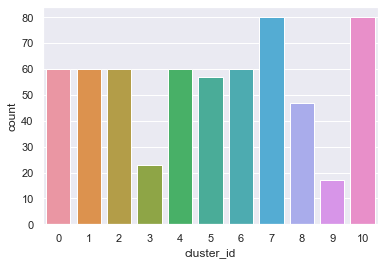

In [8]:
sns.set(rc={'figure.figsize':(8,8)})
sns.countplot(df['cluster_id'])

In [9]:
import tensorflow_hub as hub
import tensorflow as tf

embed = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [10]:
# just a random sentence
x = ["Roasted ants are a popular snack in Columbia"]

# Extract ELMo features 
embeddings = embed(x, signature="default", as_dict=True)["elmo"]

embeddings.shape

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


TensorShape([Dimension(1), Dimension(8), Dimension(1024)])

In [11]:
from sklearn import preprocessing
from tensorflow import keras 

y = list(df['cluster_id'])
x = list(df['clean_phrase'])

en = preprocessing.LabelEncoder()
en.fit(y)

def encode(en, labels):
    enc = en.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(en, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return en.inverse_transform(dec)


x_enc = x
y_enc = encode(en, y)

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np.asarray(x_enc), np.asarray(y_enc), test_size=0.2, random_state=42)

In [13]:
x_train.shape

(483,)

In [15]:
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(512, activation='relu')(embedding)
pred = Dense(11, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(x_train, y_train, epochs=5, batch_size=16)
    model.save_weights('./elmo-model.h5')

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./elmo-model.h5')  
    predicts = model.predict(x_test, batch_size=16)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Train on 483 samples
Epoch 1/5
483/483 [==============================] - 30s 63ms/sample - loss: 1.0168 - acc: 0.6894
Epoch 2/5
483/483 [==============================] - 32s 66ms/sample - loss: 0.2353 - acc: 0.9275
Epoch 3/5
483/483 [==============================] - 35s 72ms/sample - loss: 0.1094 - acc: 0.9710
Epoch 4/5
483/483 [==============================] - 34s 70ms/sample - loss: 0.0794 - acc: 0.9814
Epoch 5/5
483/483 [==============================] - 33s 68ms/sample - loss: 0.0517 - acc: 0.9876


In [16]:
# decode test labels
y_test = decode(en, y_test)
# decode predicted labels
y_preds = decode(en, predicts)

In [17]:
from sklearn import metrics

print(metrics.confusion_matrix(y_test, y_preds))

[[ 8  0  0  0  0  0  0  1  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  1]
 [ 0  0 10  0  0  0  0  0  0  0  0]
 [ 1  0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0 11  2  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  0  8  0  0  0  4]
 [ 0  0  0  0  0  0  0 14  1  0  0]
 [ 0  0  1  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  1  0  1  0 18]]


In [18]:
print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       1.00      0.95      0.97        19
           2       0.91      1.00      0.95        10
           3       1.00      0.83      0.91         6
           4       1.00      0.85      0.92        13
           5       0.82      1.00      0.90         9
           6       0.89      0.67      0.76        12
           7       0.93      0.93      0.93        15
           8       0.67      0.80      0.73         5
           9       1.00      1.00      1.00         3
          10       0.78      0.90      0.84        20

    accuracy                           0.89       121
   macro avg       0.90      0.89      0.89       121
weighted avg       0.90      0.89      0.89       121



In [19]:
from sklearn.metrics import accuracy_score

print("Accuracy of ELMO is:", accuracy_score(y_test,y_preds))

Accuracy of ELMO is: 0.8925619834710744
